In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [4]:
train_path = "/Users/egorbabic/Desktop/Project/KDDTrain+.txt"
test_path = "/Users/egorbabic/Desktop/Project/KDDTest+.txt"

In [5]:
columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
           'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
           'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
           'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
           'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
           'dst_host_srv_rerror_rate','attack','level']

In [6]:
train_df = pd.read_csv(train_path, header=None, names=columns)
test_df = pd.read_csv(test_path, header=None, names=columns)
df = pd.concat([train_df, test_df])

In [7]:
sniffer_columns = ['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
                   'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']
df = df[sniffer_columns + ['attack']].copy()

In [8]:
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [9]:
df['is_attack'] = df['attack'].apply(lambda x: 0 if x == 'normal' else 1)

X = df[sniffer_columns]
y = df['is_attack']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga', random_state=42, verbose=0))
    ]),
    "SGDClassifier": Pipeline([
        ('scaler', StandardScaler()),
        ('sgd', SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, random_state=42, verbose=0))
    ]),
    "Naive Bayes": GaussianNB(),
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(probability=True, kernel='rbf', random_state=42))
    ])
}

results = {}
logreg_losses = []
sgd_losses = []

In [14]:
for name, model in tqdm(models.items(), desc="Обучение моделей"):
    if name == "SGDClassifier":
        model.named_steps['sgd'].max_iter = 1
        model.named_steps['sgd'].warm_start = True
        model.named_steps['sgd'].loss = 'log_loss'

        for epoch in range(20):
            model.fit(X_train, y_train)
            y_prob = model.predict_proba(X_train)
            sgd_losses.append(log_loss(y_train, y_prob))
    elif name == "Logistic Regression":
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_train)
        logreg_losses.append(log_loss(y_train, y_prob))
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name}")
    print(classification_report(y_test, y_pred, digits=3))

Обучение моделей:  14%|███▊                       | 1/7 [00:05<00:30,  5.01s/it]


Random Forest
              precision    recall  f1-score   support

           0      0.993     0.996     0.995     15411
           1      0.996     0.993     0.995     14293

    accuracy                          0.995     29704
   macro avg      0.995     0.995     0.995     29704
weighted avg      0.995     0.995     0.995     29704



Обучение моделей:  29%|███████▋                   | 2/7 [00:05<00:10,  2.19s/it]


Decision Tree
              precision    recall  f1-score   support

           0      0.987     0.995     0.991     15411
           1      0.995     0.986     0.990     14293

    accuracy                          0.991     29704
   macro avg      0.991     0.990     0.991     29704
weighted avg      0.991     0.991     0.991     29704



Обучение моделей:  43%|███████████▌               | 3/7 [00:05<00:06,  1.51s/it]


KNN
              precision    recall  f1-score   support

           0      0.992     0.991     0.991     15411
           1      0.990     0.991     0.991     14293

    accuracy                          0.991     29704
   macro avg      0.991     0.991     0.991     29704
weighted avg      0.991     0.991     0.991     29704



Обучение моделей:  57%|███████████████▍           | 4/7 [00:13<00:11,  3.73s/it]


Logistic Regression
              precision    recall  f1-score   support

           0      0.867     0.933     0.899     15411
           1      0.921     0.846     0.882     14293

    accuracy                          0.891     29704
   macro avg      0.894     0.889     0.890     29704
weighted avg      0.893     0.891     0.891     29704



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reache


SGDClassifier
              precision    recall  f1-score   support

           0      0.855     0.944     0.897     15411
           1      0.932     0.827     0.876     14293

    accuracy                          0.888     29704
   macro avg      0.893     0.886     0.887     29704
weighted avg      0.892     0.888     0.887     29704


Naive Bayes
              precision    recall  f1-score   support

           0      0.518     0.996     0.682     15411
           1      0.208     0.001     0.002     14293

    accuracy                          0.517     29704
   macro avg      0.363     0.499     0.342     29704
weighted avg      0.369     0.517     0.355     29704



Обучение моделей: 100%|███████████████████████████| 7/7 [05:15<00:00, 45.01s/it]


SVM
              precision    recall  f1-score   support

           0      0.926     0.988     0.956     15411
           1      0.986     0.915     0.949     14293

    accuracy                          0.953     29704
   macro avg      0.956     0.952     0.953     29704
weighted avg      0.955     0.953     0.953     29704



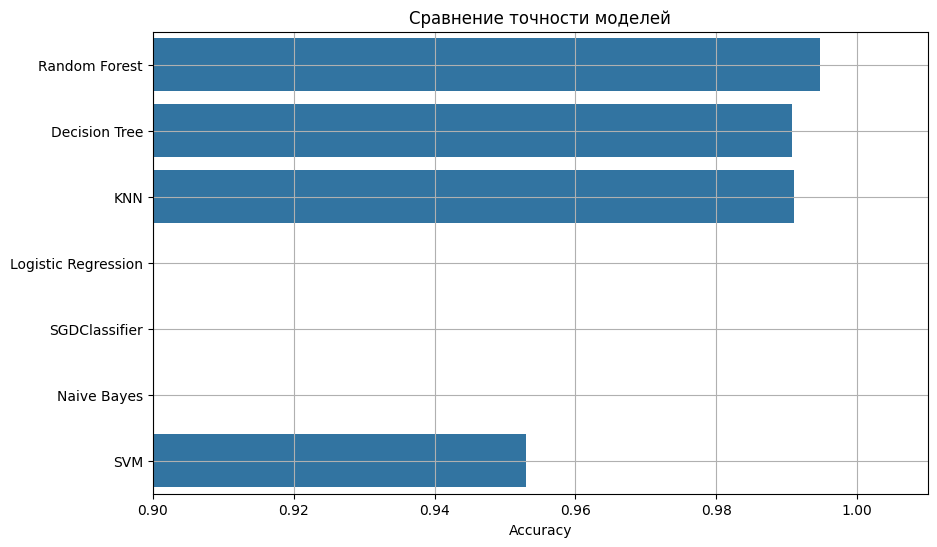

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.values()), y=list(results.keys()))
plt.title('Сравнение точности моделей')
plt.xlabel('Accuracy')
plt.xlim(0.90, 1.01)
plt.grid(True)
plt.show()

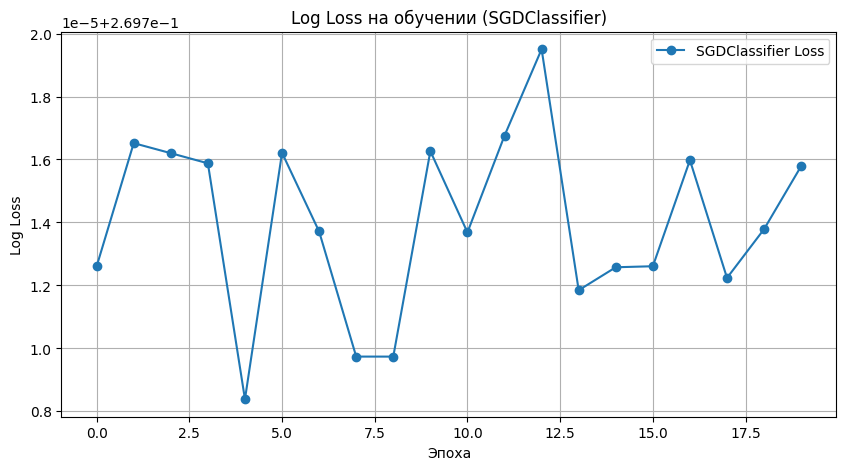

In [16]:
if sgd_losses:
    plt.figure(figsize=(10, 5))
    plt.plot(sgd_losses, marker='o', label="SGDClassifier Loss")
    plt.title("Log Loss на обучении (SGDClassifier)")
    plt.xlabel("Эпоха")
    plt.ylabel("Log Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

In [17]:
if logreg_losses:
    print(f"Log Loss (Logistic Regression): {logreg_losses[-1]:.4f}")

Log Loss (Logistic Regression): 0.2600


In [18]:
report = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    report.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, y_pred, output_dict=True)['1']['recall'],
        'F1-Score': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
    })

report_df = pd.DataFrame(report)
print("\nСравнение моделей по метрикам:")
print(report_df.sort_values(by='Accuracy', ascending=False))


Сравнение моделей по метрикам:
                 Model  Accuracy  Precision    Recall  F1-Score
0        Random Forest  0.994748   0.996140  0.992934  0.994534
2                  KNN  0.991045   0.990078  0.991324  0.990701
1        Decision Tree  0.990675   0.994845  0.985727  0.990265
6                  SVM  0.952969   0.986055  0.915203  0.949309
3  Logistic Regression  0.891126   0.921167  0.846148  0.882065
4        SGDClassifier  0.887726   0.931893  0.827118  0.876385
5          Naive Bayes  0.517304   0.207792  0.001119  0.002227
